
inladen images
resizen
bekijken van voorbeeld
hog RIDEEEEEEER, concluderen dat hog slecht is
surf uitproberen, en zeggen dat dat niet lukte omdat gepatenteerd
sift (xander zijn comments)
recommendation system HIKMAT, input image output restaurnat
ram deel, classifciatie
regressie op iets
nog extra ideeen

# Sprint 2

In this sprint we used clustering, classification and regression on the tripadvisor dataset.

## Resizing our image dataset

We will do this once (in parallel) and then save them so the next time we load our images it doesn't take too long. This resize keeps the aspect ratio.

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from fastai.vision.all import *
import matplotlib.pyplot as plt

original_path = Path('tripadvisor_dataset/tripadvisor_images')
trns_path = Path('tripadvisor_dataset/tripadvisor_images_small')
trns_path.mkdir(exist_ok=True)

# max_workers = amount of cores

if os.listdir(trns_path)==[]:
    resize_images(original_path, max_workers=4, dest=trns_path, max_size=256)

## Creating our dataset of images

Let's look at some images

((256, 192), (256, 256))

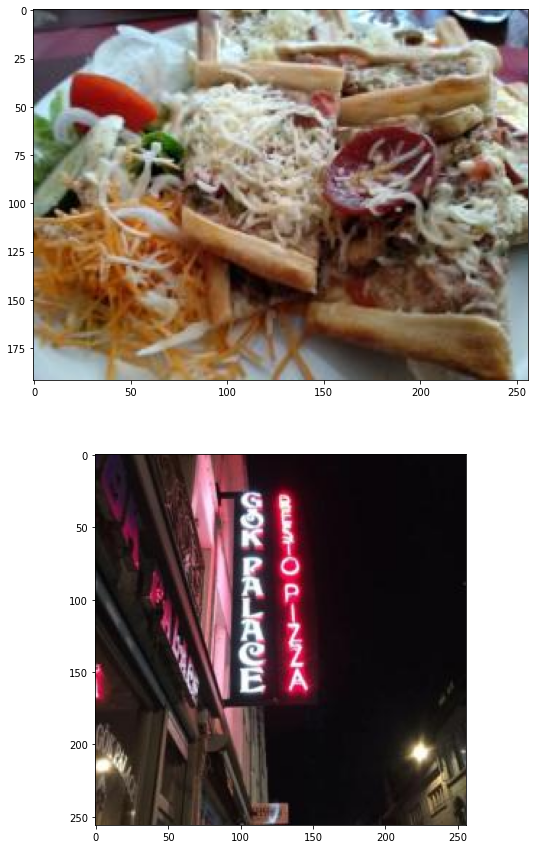

In [2]:
img_folder = "./tripadvisor_dataset/tripadvisor_images_small"
image_files=os.listdir(img_folder)
fig=plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
img1=PILImage.create(os.path.join(img_folder,image_files[0]))
plt.imshow(img1)
plt.subplot(2,1,2)
img2=PILImage.create(os.path.join(img_folder,image_files[1]))
plt.imshow(img2)
img1.size,img2.size

We can already see that our images have different sizes and not all of our pictures are pictures of food. So let's resize them.

In [3]:
# Resizing to this sizes
IMG_HEIGHT = 128
IMG_WIDTH = 128

def create_dataset(img_folder, n=None):
    # n = amount of images
    image_files=os.listdir(os.path.join(img_folder))
    if n==None:
        n=len(image_files)
    images = np.zeros((n, IMG_HEIGHT* IMG_WIDTH* 3))
    for i,file in enumerate(image_files[:n]):
        # print(f"{i},{file}")
        img=PILImage.create(os.path.join(img_folder,file))
        img_resized=img.resize((IMG_HEIGHT,IMG_WIDTH))
        img_np=np.array(img_resized).flatten()
        images[i]=img_np/255
    return images

images = create_dataset(img_folder, 100)

Lets look at some of our cropped images

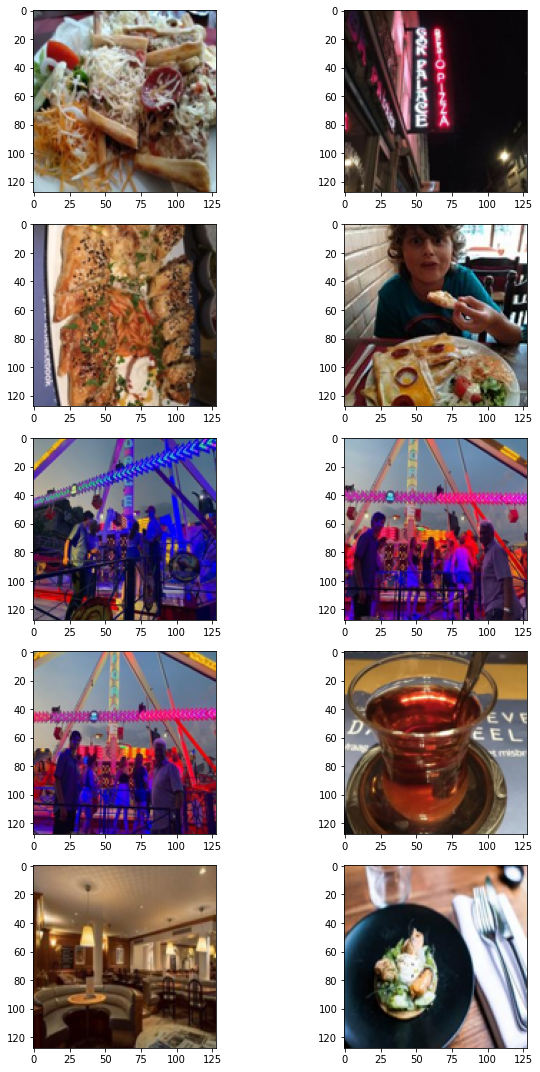

In [4]:
fig=plt.figure(figsize=(10,15))
for i in range(0,10):
    plt.subplot(5,2,i+1)
    plt.imshow(images[i].reshape(IMG_HEIGHT,IMG_WIDTH,3))
fig.tight_layout()
plt.show()

Not all of these images are usefull, we will have to find a way to clean our dataset because we know: garbage in is garbage out. For our ideas we need specifically images of food, images that contain buildings etc needs to be filtered out.

We will first start with feature extraction followed by an initial clustering to find a way to separate the food images from the non food images.

## Feature extraction - part 1
We will first start with the basic HOG algorithm that we have seen in our lab.

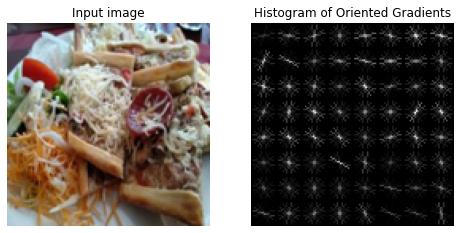

In [5]:
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

img = images[0].reshape(IMG_HEIGHT,IMG_WIDTH,3)

fd, hog_image = hog(img,orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

This is what we get from 1 picture, now let's apply it to our whole dataset

In [6]:
images_hogs = np.zeros((images.shape[0], 512 * 3))

for i, img in tqdm(enumerate(images), total=len(images)):
    img = img.reshape((128,128,3))
    for channel in range(3):
        fd = hog(img[:,:,channel], orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        images_hogs[i, channel*512:channel*512+512] = fd


100%|██████████| 100/100 [00:02<00:00, 41.12it/s]


In [7]:
images_hogs.shape

(100, 1536)

## Clustering
We start with standardizing our data

In [8]:
from sklearn.preprocessing import StandardScaler
# scale hog features
sc = StandardScaler()
hogs_scaled = sc.fit_transform(images_hogs)

Before we start with dimensionality reduction, we will make an initial clustering to get to know our data better and see if it's easy to separate the food images from the non food images.

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
predictions = kmeans.fit_predict(hogs_scaled)

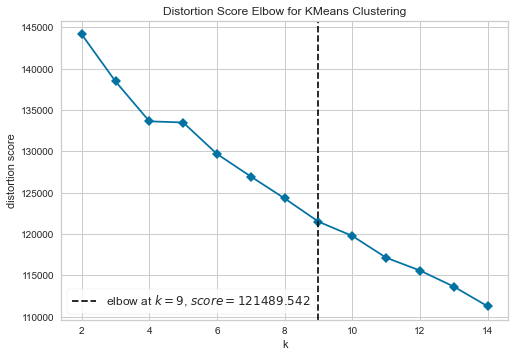

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()

visualiser = KElbowVisualizer(model, k=(2,15), timings=False)

visualiser.fit(hogs_scaled)
visualiser.show()

Not really a good sign, it doesn't have the distict elbow shape, maybe it's because of our feature extraction. We try it again without the hogs but on our raw pixel data

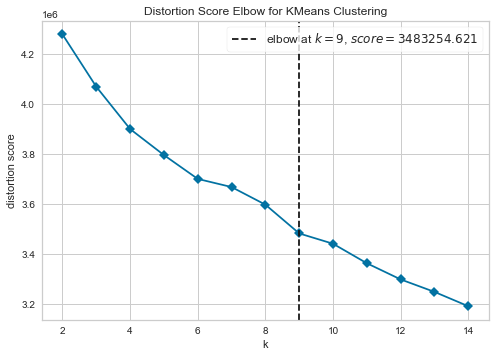

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()

visualiser = KElbowVisualizer(model, k=(2,15), timings=False)

visualiser.fit(StandardScaler().fit_transform(images))
visualiser.show()

Still the same result sadly, let's see what's in the clusters.

TODO: beter resultaat, niet? ik heb met meer fotos geprobeerd. Stel dit was ook slecht, dan maakt het toch niet uit of we HOGS of SURF zouden proberen want als het op de originele data al slecht zou zijn... 
Maar het is beter en HOG grafiek ziet er wel slechter uit

CLUSTER 0


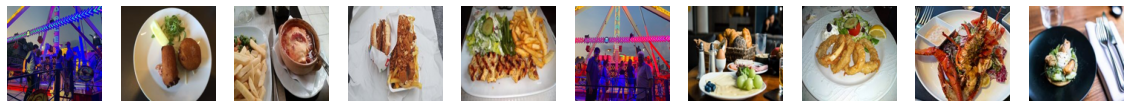

CLUSTER 1


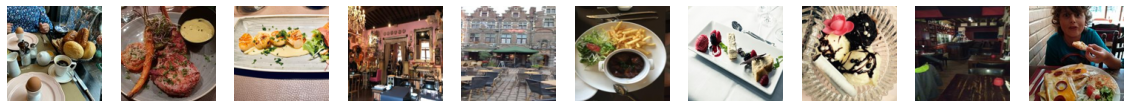

In [12]:
# you can optionally give this function the distances of the instances to the cluster centers (obtainable by using the models transform function)
def show_predictions(predictions, n_clusters, images, distances=None):
    for cluster in range(n_clusters):
        print(f"CLUSTER {cluster}")

        cluster_images = images[np.where(predictions == cluster)]

        if distances is not None:
            # we sort the images so that they are displayed in order of distance to cluster center
            cluster_distances=  np.min(distances[np.where(predictions == cluster)], axis=1)
            cluster_instances_sorted = np.argsort(cluster_distances)
            cluster_images = cluster_images[cluster_instances_sorted[::-1]]
                
        num_pics = 10 if cluster_images.shape[0] > 10 else cluster_images.shape[0]

        # try to pick out images closes to the cluster centers
        if num_pics == 0:
            print("No images in this cluster")
            continue
        if num_pics == 1:
            plt.figure()
            plt.imshow(cluster_images[0].reshape((128,128,3)))
            plt.axis("off")
            plt.show()
            continue
        indices = np.random.choice(np.arange(cluster_images.shape[0]), num_pics, replace=False)
        _, axs = plt.subplots(1, num_pics, figsize=(20,20))
        axs = axs.flatten()
        for img, ax in zip(cluster_images[indices], axs):
            ax.imshow(img.reshape((128,128,3)))
            ax.set_axis_off()
        plt.show()

show_predictions(predictions, 2, images)

The result after clustering on the HOG images is not desirable. The histogram of gradients maybe isn't the best way to cluster dishes. In the next step we will try out other feature extraction techniques and compare them by visual result and on the silhouette score and plot.

We can also see there there are copies of the same image, it's best to also remove them

## Feature extraction - part 2

We'll try an alternative to HOG, namely SIFT and SURF. 

### SURF
Speeded up robust features (SURF) is a patented local feature detector and descriptor. It can be used for tasks such as object recognition, image registration, classification, or 3D reconstruction. It is partly inspired by the scale-invariant feature transform (SIFT) descriptor. The strength of the SURF algorithm uses box filters as seen below. This enables object recognition and tracking possibilities. However this algorithm is pattented and not availaible in the ```opencv-contribute``` module that we used. So we decided to switch to SIFT.


Image


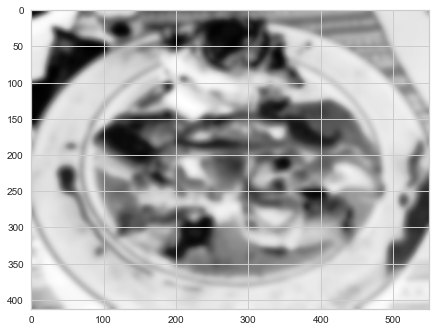

No of  points: 316


(316, 70)

In [13]:
import mahotas
import mahotas.demos
import mahotas as mh
import numpy as np
from pylab import imshow, show
from mahotas.features import surf
import cv2
 
# loading image
image = cv2.imread(r'tripadvisor_dataset/tripadvisor_images/694642_0.jpg', cv2.COLOR_BGR2RGB)[..., ::-1]

# removing color
nuclear = image[:, :, 0]
 
# adding gaussian filter
nuclear = mahotas.gaussian_filter(nuclear, 4)
 
# showing image
print("Image")
# imshow(image)
imshow(nuclear)

show()
 
 
# getting Speeded-Up Robust Features
spoints = surf.surf(nuclear)
print("No of  points: {}".format(len(spoints)))
spoints.shape

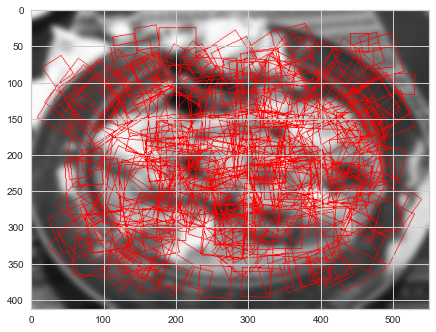

In [14]:
f2 = surf.show_surf(nuclear, spoints)
imshow(f2)

### SIFT (Scale-Invariant Featue Transform)
SIFT is a computer vision algorithm that detects and describes local features in images. The result of the SIFT features is that the detection is invariant to scale and rotation. This can be handy because we can see that the dishes are twisted and turned in all possible directions.

The algorithm proceeds as follows:

    1) Scale-space peak selection: Potential location for finding features
    2) Keypoint Localization: Accurately locating the feature keypoints
    3) Orientation Assignment: Assigning orientation to keypoints
    4) Keypoint descriptor: Describing the keypoints as a high dimensional vector
    5) Keypoint Matching
  
source: https://medium.com/@deepanshut041/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40

Number of Keypoints Detected In The Training Image:  142
Number of Keypoints Detected In The Query Image:  142


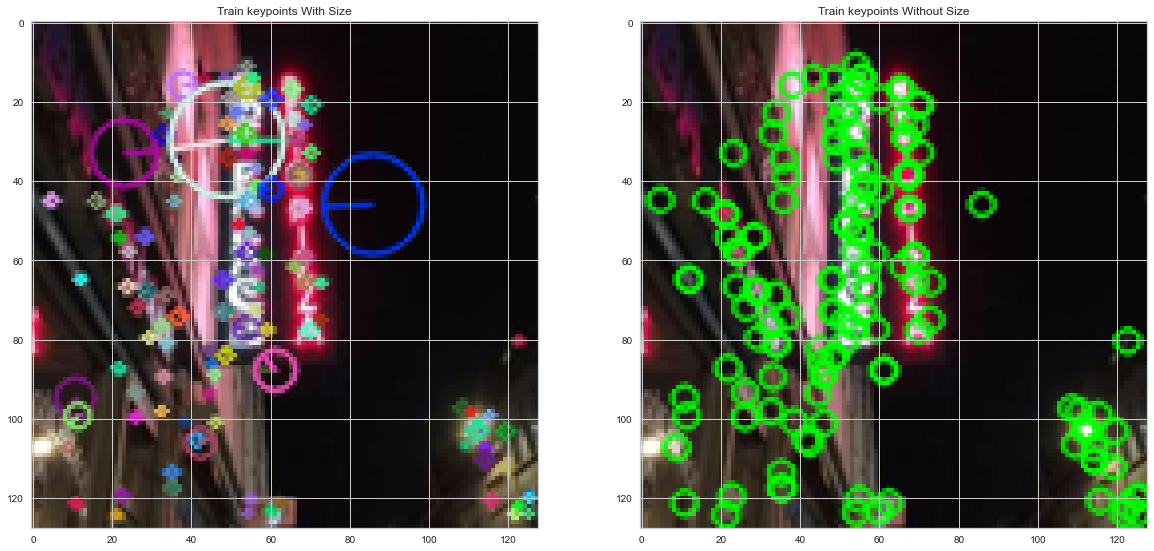

In [15]:
import cv2
sift = cv2.xfeatures2d.SIFT_create()

img = images[1].reshape(IMG_HEIGHT,IMG_WIDTH,3)

# SIFT function only accepts images with 8 bit integer values
image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Convert the training image to gray scale
training_gray = cv2.cvtColor(image8bit, cv2.COLOR_RGB2GRAY)


train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(training_gray, None)

keypoints_without_size = np.copy(image8bit)
keypoints_with_size = np.copy(image8bit)

cv2.drawKeypoints(image8bit, train_keypoints, keypoints_without_size, color = (0, 255, 0))
cv2.drawKeypoints(image8bit, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

In the pictures you can see examples of keypoints of the keypoint descriptor of SIFT. Keypoints between two different images can be matched by identifying their nearest neighbours.

For the matching of the pictures we will apply kmeans on the descriptors to create visual words. 

First we extract the keypoints and descriptors from every image

In [16]:
def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    features = []
    sift = cv2.xfeatures2d.SIFT_create()
    for img in images:
        img = img.reshape(IMG_HEIGHT,IMG_WIDTH,3)
        # SIFT function only accepts images with 8 bit integer values
        image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

        # Convert the training image to gray scale
        training_gray = cv2.cvtColor(image8bit, cv2.COLOR_RGB2GRAY)


        keypoints, descriptor = sift.detectAndCompute(training_gray, None)
        descriptor_list.extend(descriptor)
        features.append(keypoints)


    return (descriptor_list, np.array(features))


descriptors, features = sift_features(images)


C:\Users\hikma\AppData\Local\Temp\ipykernel_12040\586068018.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (descriptor_list, np.array(features))


In [17]:
descriptors[0].shape # descriptors is a list

(128,)

aanpassen

We now have an array with a huge number of descriptors. We cannot use all of them to create the model, so we need to cluster them. A rule-of-thumb is to create k centers with k = number of categories * 10.

In [24]:
from sklearn.cluster import KMeans

number_of_categories = 2

def kmeans(descriptor_list):
    k = number_of_categories * 10
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words

visual_words = kmeans(descriptors)
visual_words

array([[10.63070539, 13.89937759, 20.66908714, ..., 17.39004149,
        16.5840249 , 19.19709544],
       [28.07994186, 21.26017442, 17.39098837, ...,  8.75290698,
        11.59593023, 41.48837209],
       [33.23329426, 30.35287222, 24.55685815, ...,  6.31418523,
         7.98241501, 11.8147714 ],
       ...,
       [31.00890585, 54.74045802, 44.9605598 , ...,  9.41475827,
         8.28625954, 13.36132316],
       [23.29368932, 27.70145631, 28.46966019, ..., 29.37378641,
        39.6711165 , 27.79004854],
       [13.68692661, 11.65481651, 13.99426606, ...,  8.05389908,
         8.82110092, 13.56192661]])

### Making histograms


In [25]:
# Find the index of the closest central point to the each sift descriptor. 
# Takes 2 parameters the first one is a sift descriptor and the second one is the array of central points in k means
# Returns the index of the closest central point.  
from scipy.spatial import distance

def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i]) 
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i]) 
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

In [26]:
def image_class(features, centers, descriptors):
    begin = 0
    histogrammen = []
    for f in features:
        histogram = np.zeros(len(centers))
        for i in range(begin, begin + len(f)):
            ind = find_index(descriptors[i], centers)
            histogram[ind] += 1
        histogrammen.append(histogram)
        begin += len(f)

    return histogrammen


image_features = image_class(features, visual_words, descriptors)

In [27]:
print(len(image_features)) # amount of images
image_features[0].shape # amount of centroids

100


(20,)

Now we really cluster the image based on the histograms. First we will try default clustering.

In [28]:
kmeans = KMeans(2)
sift = kmeans.fit_predict(image_features)

CLUSTER 0


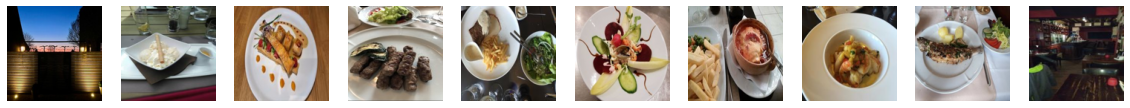

CLUSTER 1


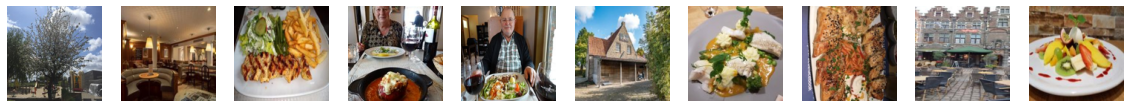

In [29]:
show_predictions(sift, 2, images)

From these experiments we concluded that we don't have a good way to measure the performance of our clusterng. If we don't have a way to evaluate the performance of the model we don't know which cluster method or feature extraction would be better. To solve this we perform the same methods on a similar labelled dataset of food and buildings that we obtained from kaggle.

The search of an optimal cluster algorithm will continue in TODO notebook.ipynb and we use now the best cluster algorithm that was concluded from the other notebook.

## Idea 1: Recommendation system

The idea is that a model will return restaurants correlated with the input. The model will cluster all the images of the restaurants. As input a user gives an image (for example a picture of pasta) and see in which cluster it ends up. All the restaurants from the images in that cluster will be recommended to the user. (TODO: idee, miss sorteren van welke punten dat het dichtste zijn)